### Install and import packages

In [ ]:
# Install packages
!pip install bayes_logistic

In [1]:
# Import packages
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

color_list = ["Green", "Blue"]
color_map = mcolors.ListedColormap(["Green", "Blue"])

import seaborn as sns
sns.set()
sns.set_palette("tab10")

import random as rnd
import numpy as np
rnd.seed(0)
np.random.seed(0)

import scipy.stats as stats
import bayes_logistic

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.nn import PyroModule, PyroSample

### Set parameters

In [10]:
# Set parameters
# num_data
num_feats = 100
num_data = 2
num_data_half = num_data // 2

# num_samples 
num_samples = 1000

# data_x marginal distribution parameters
c0_mu = np.ones(num_feats)*(-1)
c1_mu = np.ones(num_feats)*5

c0_cov = np.identity(num_feats)
c1_cov = np.identity(num_feats)*3
# c0_cov = generate_psd_matrix(num_feats)
# c1_cov = generate_psd_matrix(num_feats)*3

data_x_marginal_params = [
    [c0_mu, c0_cov],
    [c1_mu, c1_cov]]

# weights prior distribution parameters
weights_prior_mu = np.zeros(num_feats)
weights_prior_cov = np.identity(num_feats)
weights_prior_params = [weights_prior_mu, weights_prior_cov]

# SVI training parameters
svi_num_iters = 59


### Generate data_x

$$
\begin{align*}
  \mathrm{data}\_x &= \rm{U}(0,1)\\
\end{align*}
$$


In [5]:
# Generate data_x
data_x_marginal_dists = [
    stats.multivariate_normal(mu, sigma, seed=12345) \
        for mu, sigma in data_x_marginal_params]

c0_x = data_x_marginal_dists[0].rvs(size=(num_data_half))
c1_x = data_x_marginal_dists[1].rvs(size=(num_data_half))
data_x = np.vstack((c0_x, c1_x))
data_x = np.random.randn(num_data, num_feats)
print(data_x.shape)

(2, 2)


### Sample weights, generate sample y from sample weights and visualize data

#### Comments on the plots
1. Even though the data_x is set to be linearly separable, using random prior weights can lead to linearly nonseparable cases.

### Generate prior and posterior samples

Generate two set of prior samples A and B

$$
\begin{align*}
    & A = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta) \\
    & B = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta)
\end{align*}
$$

Generate a set of posterior from prior samples A

Notes: 
- $x$ is fixed and generated from the above procedure. Only $y_i$ is generated from $\theta_i$.

$$
\begin{align*}
    & C' = \{ \theta_i' \}_{i=1}^N, \\
    & \theta_i' \sim p(\theta|x, y_i), \\
    & y_i \sim p(y_i|x, \theta_i), \; \theta_i \in A
\end{align*}
$$

In [14]:
### Generate prior and posterior samples

# weights' prior distribution
weights_prior_dist_a = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=1)
weights_prior_dist_b = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=11)

def logistic_regression_model(x, y):
    num_data, num_feats = x.shape
    # set prior  
    w = pyro.sample("w", dist.MultivariateNormal(
        torch.tensor(weights_prior_params[0], dtype=torch.float).reshape(1, num_feats),
        torch.tensor(weights_prior_params[1], dtype=torch.float)).to_event(1))
    
    # compute ymean and sample
    ymean = torch.sigmoid(torch.matmul(x, w.squeeze(1).T)).squeeze(-1)
    with pyro.plate("data", x.shape[0]):
        pyro.sample("y", dist.Bernoulli(ymean), obs=y)
        
# def logistic_regression_guide(x, y):
#     num_data, num_feats = x.shape
#     w_loc = pyro.param("w_loc", torch.zeros(num_feats))
#     w_scale = pyro.param('w_scale', torch.ones(num_feats), constraint=constraints.positive)
#     pyro.sample('w', dist.Normal(w_loc, w_scale).to_event(1))

data_x_torch = torch.tensor(data_x, dtype=torch.float)

samples_a_weights_prior = []
samples_b_weights_prior = []
samples_a_weights_posterior = []
svi_num_iters = 100
for sidx in range(num_samples):
    if sidx % 100 == 0:
        print(f"working on sample: {sidx}")
    # sample two set of weights' priors 
    sample_a_weights_prior = weights_prior_dist_a.rvs(1)[None,:]
    sample_b_weights_prior = weights_prior_dist_b.rvs(1)[None,:]
    samples_a_weights_prior.append(sample_a_weights_prior)
    samples_b_weights_prior.append(sample_b_weights_prior)
    # print(sample_a_weights_prior.shape)
    # print(sample_b_weights_prior.shape)
    
    # generate sample y_i from theta_i in A
    sample_a_logit = 1.0 / (1 + np.exp(-np.matmul(data_x, sample_a_weights_prior.T)))
    sample_a_y = stats.bernoulli.rvs(sample_a_logit)
    sample_a_y = torch.tensor(sample_a_y, dtype=torch.float).squeeze(-1)
    # print(sample_a_y.shape)
    # stop

    # sample weights' posterior using SVI
    diagonal_normal_guide = pyro.infer.autoguide.AutoDiagonalNormal(logistic_regression_model)
    optim = pyro.optim.Adam({"lr": 0.03})
    svi = pyro.infer.SVI(
        logistic_regression_model, diagonal_normal_guide, optim, loss=pyro.infer.Trace_ELBO())
    
    pyro.clear_param_store()
    for it in range(svi_num_iters):
        # calculate the loss and take a gradient step
        loss = svi.step(data_x_torch, sample_a_y.squeeze(-1))
        # if i % 100 == 0:
        #     print("[iteration %04d] loss: %.4f" % (i, loss / len(data_x)))
        
    predictive_fn = pyro.infer.Predictive(
        logistic_regression_model, guide=diagonal_normal_guide, num_samples=1)

    svi_samples = predictive_fn(data_x_torch, sample_a_y)
    sample_a_weights_posterior = svi_samples["w"].reshape(1, num_feats)
    samples_a_weights_posterior.append(sample_a_weights_posterior.data.cpu().numpy())

samples_a_weights_prior = np.vstack(samples_a_weights_prior)
samples_b_weights_prior = np.vstack(samples_b_weights_prior)
samples_a_weights_posterior = np.vstack(samples_a_weights_posterior)
print(samples_a_weights_prior.shape)
print(samples_b_weights_prior.shape)
print(samples_a_weights_posterior.shape)

working on sample: 0
working on sample: 100
working on sample: 200
working on sample: 300
working on sample: 400
working on sample: 500
working on sample: 600
working on sample: 700
working on sample: 800
working on sample: 900
(1000, 2)
(1000, 2)
(1000, 2)


### Visualize the generated prior and posterior samples 

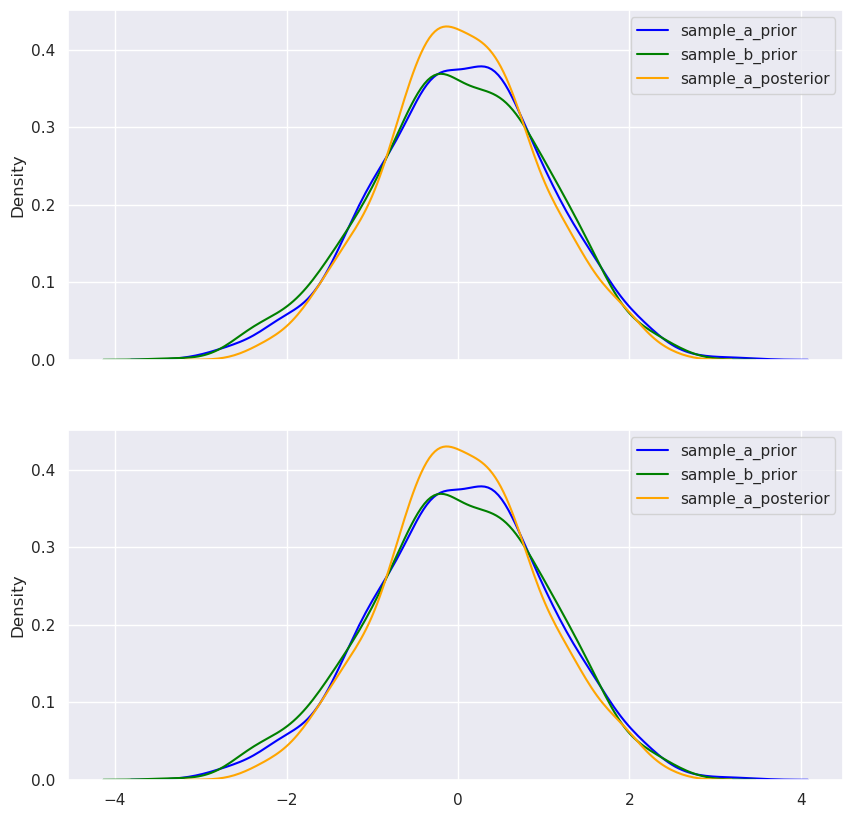

In [15]:
# Visualize the generated prior and posterior samples 
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

for i in range(nrows):
    sns.kdeplot(samples_a_weights_prior[:,0], fill=False, color="blue", label="sample_a_prior", ax=axes[i])
    sns.kdeplot(samples_b_weights_prior[:,0], fill=False, color="green", label="sample_b_prior", ax=axes[i])
    sns.kdeplot(samples_a_weights_posterior[:,0], fill=False, color="orange", label="sample_a_posterior", ax=axes[i])
    axes[i].legend()
plt.show()

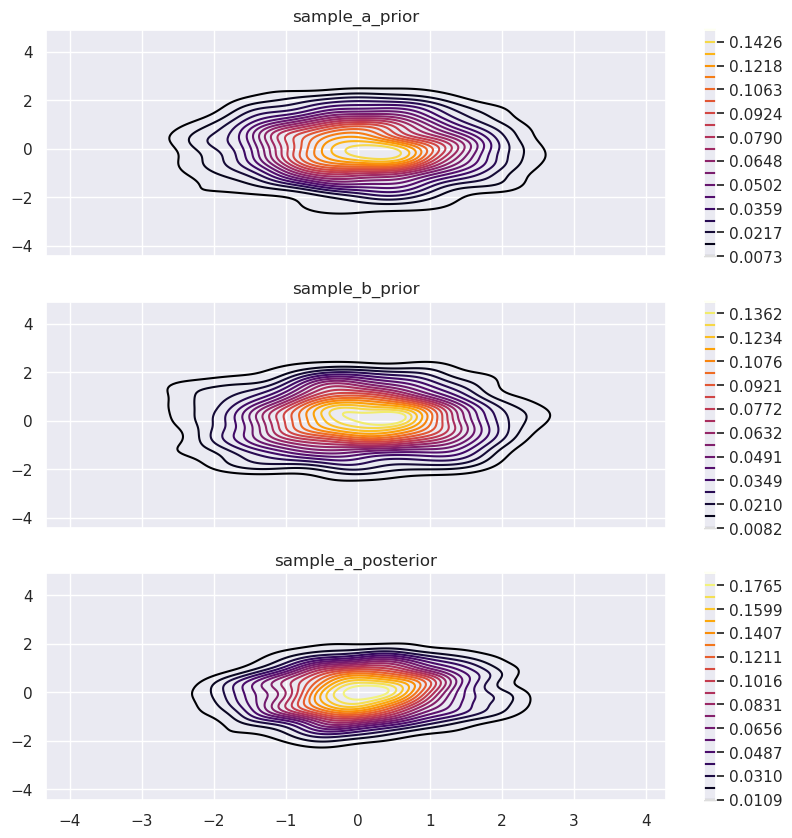

In [16]:
# Visualize the generated prior and posterior samples 
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

sns.kdeplot(x=samples_a_weights_prior[:,0], y=samples_a_weights_prior[:,1], n_levels=20, 
            cmap="inferno", fill=False, cbar=True, ax=axes[0])

sns.kdeplot(x=samples_b_weights_prior[:,0], y=samples_b_weights_prior[:,1], n_levels=20, 
            cmap="inferno", fill=False, cbar=True, ax=axes[1])

sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], n_levels=20, 
            cmap="inferno", fill=False, cbar=True, ax=axes[2])
axes[0].set_title("sample_a_prior")
axes[1].set_title("sample_b_prior")
axes[2].set_title("sample_a_posterior")
plt.show()

#### Comments on the plots
1. In 2d, the posterior samples are quite different from the prior samples 